In [1]:
# first neural network with keras tutorial
import pandas as pd
import pandas_ta as ta
import random
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Flatten, Activation, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, ModelCheckpoint, Callback, TensorBoard, LearningRateScheduler
import time
import statistics
from matplotlib import pyplot as plt
import os.path
from numpy import loadtxt
import yfinance as yf
import math
pd.options.mode.chained_assignment = None  # default='warn'

In [4]:
## getting data ##
def getDF():
    # Load data
    df = pd.read_csv('data/BTC-USD_30min.csv')
    df = df.drop(columns=['Unnamed: 0'])
    df = df.tail(1200)
    
    # add data points #
    
    # closing percents
    df['close_per1'] = df.ta.percent_return(length=1, close = df['close'])*100
    df['close_per3'] = df.ta.percent_return(length=4, close = df['close'])*100
    
    # ema
    df['ema10'] = df.ta.ema(length=10, close = df['close'])
    df['ema3'] = df.ta.ema(length=3, close = df['close'])
    
    # rsi
    df['rsi7'] = df.ta.rsi(length=7, close = df['close'])/100
    df['rsi14'] = df.ta.rsi(length=14, close = df['close'])/100
    
    # willr
    df['williams7'] = df.ta.willr(length=7, close = df['close'])/100
    df['williams14'] = df.ta.willr(length=14, close = df['close'])/100
    
    # stochrsi
    df_stochrsi7 = df.ta.stochrsi(length=7, rsi_length=7)
    df_stochrsi14 = df.ta.stochrsi(length=14, rsi_length=14)
    df_stochrsi7['stochrsi_hist7'] = df_stochrsi7['STOCHRSIk_7_7_3_3'] - df_stochrsi7['STOCHRSId_7_7_3_3']
    df_stochrsi14['stochrsi_hist14'] = df_stochrsi14['STOCHRSIk_14_14_3_3'] - df_stochrsi14['STOCHRSId_14_14_3_3']
    df['stochrsi_hist7'] = (df_stochrsi7['STOCHRSIk_7_7_3_3'] - df_stochrsi7['STOCHRSId_7_7_3_3'])/100
    df['stochrsi_hist14'] = (df_stochrsi14['STOCHRSIk_14_14_3_3'] - df_stochrsi14['STOCHRSId_14_14_3_3'])/100
    
    # BBands %
    df_bbands = df.ta.bbands()
    df['BB_perL'] = -1*((df_bbands['BBM_5_2.0']-df_bbands['BBL_5_2.0'])/df_bbands['BBM_5_2.0'])
    df['BB_perH'] = -1*((df_bbands['BBM_5_2.0']-df_bbands['BBU_5_2.0'])/df_bbands['BBM_5_2.0'])
    

#     del df['timestamp']
    del df['trades']
    del df['volume']
    
    df = df.dropna()
    df.reset_index(inplace=True)
    
    return df

In [5]:
ticker = "TNA"
df = getDF()
df.tail(5)

,index,timestamp,open,high,low,close,close_per1,close_per3,ema10,ema3,rsi7,rsi14,williams7,williams14,stochrsi_hist7,stochrsi_hist14,BB_perL,BB_perH
1164,3736,02-03-2022 22:00:00,43826.82,44115.17,43802.58,44103.07,0.644353,0.854505,43895.832306,43954.332442,0.603772,0.531707,-0.018540,-0.657434,0.116417,0.097292,-0.006576,0.006576
1165,3737,02-03-2022 22:30:00,44088.91,44380.88,43899.15,44065.61,-0.084937,0.632860,43926.700978,44009.971221,0.580193,0.522745,-0.343297,-0.483912,0.011882,0.180426,-0.006769,0.006769
1166,3738,02-03-2022 23:00:00,44065.54,44244.40,43976.96,44111.43,0.103981,0.621708,43960.288073,44060.700611,0.602353,0.533111,-0.297055,-0.375135,0.002841,0.218317,-0.006617,0.006617
1167,3739,02-03-2022 23:30:00,44071.53,44212.41,44038.02,44045.22,-0.150097,0.512338,43975.730241,44052.960305,0.553130,0.515681,-0.501689,-0.432641,-0.065039,0.101794,-0.005435,0.005435
1168,3740,03-03-2022 00:00:00,44005.14,44065.35,43875.19,43936.72,-0.246338,-0.377185,43968.637470,43994.840153,0.478390,0.487550,-0.681269,-0.516201,-0.214375,-0.037596,-0.003183,0.003183


In [6]:
df.columns

Index(['index', 'timestamp', 'open', 'high', 'low', 'close', 'close_per1',
       'close_per3', 'ema10', 'ema3', 'rsi7', 'rsi14', 'williams7',
       'williams14', 'stochrsi_hist7', 'stochrsi_hist14', 'BB_perL',
       'BB_perH'],
      dtype='object')

In [17]:
# start classifying 
def classify(df):
    std_constant = 0.65
    # handling the target data outputs (3 days)
    df['close_per3_shifted'] = df['close_per3'].shift(-4)
    df = df.dropna()
    
    value = df['close_per3_shifted'].std()*std_constant
    print("std: {}".format(round(float(value),2)))
    
    # this is the target column
    target_per = list(df['close_per3_shifted'])
    
    target = []
    for i in target_per:
        if i > value:
            target.append(2)
        elif i < -value:
            target.append(1)
        else:
            target.append(0)
    df['target'] = target
    
    
    # setting the model inputs for close to close percent change (1 days)
    value = df['close_per1'].std()*std_constant
    LIST_op1 = list(df['close_per1'])
    for i in range(len(LIST_op1)):
        if LIST_op1[i] > value:
            LIST_op1[i] = 1
        elif LIST_op1[i] < -value:
            LIST_op1[i] = -1
        else:
            LIST_op1[i] = 0
    df['O_O_percent1'] = LIST_op1
    
    
    # setting the model inputs for close to close percent change (3 days)
    value = df['close_per3'].std()*std_constant
    LIST_op3 = list(df['close_per3'])
    for i in range(len(LIST_op3)):
        if LIST_op3[i] > value:
            LIST_op3[i] = 1
        elif LIST_op3[i] < -value:
            LIST_op3[i] = -1
        else:
            LIST_op3[i] = 0
    df['O_O_percent3'] = LIST_op3
    
    

    LISTsma10 = list(df['ema10'])
    LISTsma3 = list(df['ema3'])
    for i in range(len(LISTsma10)):
        if LISTsma10[i] > df.iloc[i]['close']:
            LISTsma10[i] = 1
        else:
            LISTsma10[i] = 0
        if LISTsma3[i] > df.iloc[i]['close']:
            LISTsma3[i] = 1
        else:
            LISTsma3[i] = 0
    df['ema10'] = LISTsma10
    df['ema3'] = LISTsma3
    
    
    
    df = df.dropna()
    
    # ['index', 'timestamp', 'open', 'high', 'low', 'close', 'close_per1',
    #  'close_per3', 'ema10', 'ema3', 'rsi7', 'rsi14', 'williams7',
    #   'williams14', 'stochrsi_hist7', 'stochrsi_hist14', 'BB_perL',
    #   'BB_perH']
    
    # picking out the columns I want for the model
    df = df[[
            'ema3','ema10',\
            'rsi7','rsi14',\
            'williams7','williams14',\
            'stochrsi_hist7','stochrsi_hist14',\
            'BB_perL','BB_perH',\
            'O_O_percent3','O_O_percent1',\
            'target','close_per3_shifted'
            ]]
    
#     # picking out the columns I want for the model
#     df = df[[
#             'ema3','ema10',\
#             'rsi7','rsi14',\
#             'williams7','williams14',\
#             'stochrsi_hist7','stochrsi_hist14',\
#             'BB_perL','BB_perH',\
#             'target','close_per3_shifted'
#             ]]

    
    
    # converting the df to array
    dataset = df.to_numpy()
    
    return dataset

In [19]:
ticker = "TNA"
df = getDF()
dataset = classify(df)
# dataset.tail(5)
# dataset

std: 0.72


In [20]:
dataset[0]


array([ 0.        ,  1.        ,  0.48072246,  0.49133089, -0.62544808,
       -0.62544808, -0.20260742, -0.1919906 , -0.00945086,  0.00945086,
        0.        ,  0.        ,  0.        ,  0.31217539])

In [21]:
def trainData(SEQ_LEN, SHIFT, tickers):
    Sequential_data = []
    for ticker in tickers:
        df = getDF()
        dataset = classify(df)

        dataset = dataset[0:-int(SHIFT)]
        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

        for i in dataset:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!


        random.shuffle(sequential_data)  # shuffle for good measure.

        buy = []; notbuy = []; maybe = []

        for seq, target, percentage in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target, percentage])
            elif target == 1:
                notbuy.append([seq, target, percentage]) 
            elif target == 2:
                buy.append([seq, target, percentage])  

        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)

        lower = min(len(buy), len(notbuy), len(maybe))  # what's the shorter length?

        # make sure lists are only up to the shortest length.
        buy = buy[:lower]  
        notbuy = notbuy[:lower]
        maybe = maybe[:lower]

        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
        
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []; p = []
    for seq, target, percentage in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        p.append(percentage)  # y is the targets/labels (buys vs sell/notbuy)

            
    return np.array(X).astype("float64"), np.array(y).astype("uint8"), p



In [22]:
def testData(SEQ_LEN, SHIFT, tickers):
    Sequential_data = []
    for ticker in tickers:
        df = getDF()
        dataset = classify(df)

        dataset = dataset[-int(SHIFT):]
        sequential_data = []  # this is a list that will CONTAIN the sequences
        prev_days = deque(maxlen=SEQ_LEN)  # These will be our actual sequences. They are made with deque, which keeps the maximum length by popping out older values as new ones come in

        for i in dataset:  # iterate over the values
            prev_days.append([n for n in i[:-2]])  # store all but the target
            if len(prev_days) == SEQ_LEN:  # make sure we have 60 sequences!
                sequential_data.append([np.array(prev_days), i[-2], i[-1]])  # append those bad boys!


        random.shuffle(sequential_data)  # shuffle for good measure.

        buy = []; notbuy = []; maybe = []

        for seq, target, percentage in sequential_data:  # iterate over the sequential data
            if target == 0:
                maybe.append([seq, target, percentage])
            elif target == 1:
                notbuy.append([seq, target, percentage]) 
            elif target == 2:
                buy.append([seq, target, percentage])  

        # suffle data
        random.shuffle(buy)
        random.shuffle(notbuy)
        random.shuffle(maybe)

        sequential_data = buy+notbuy+maybe # add them together
        random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.
        
        Sequential_data = Sequential_data + sequential_data
        
    random.shuffle(Sequential_data)
    X = []; y = []; p = []
    for seq, target, percentage in Sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)
        p.append(percentage)  # y is the targets/labels (buys vs sell/notbuy)

            
    return np.array(X).astype("float64"), np.array(y).astype("uint8"), p



In [23]:
tickers = ["BTC"]
SHIFT = 200
SEQ_LEN = 1
trainX, trainY, trainPercent = trainData(SEQ_LEN, SHIFT, tickers)
validationX, validationY, validationPercent = testData(SEQ_LEN, SHIFT, tickers)
print("tickers: {}, train length: {}, validation length: {}".format(tickers, len(trainX), len(validationX)))

std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 200


In [24]:
trainX[0][0]

array([ 0.        ,  0.        ,  0.530664  ,  0.46768099, -0.16571173,
       -0.39664837,  0.09864831,  0.10337372, -0.00555554,  0.00555554,
        0.        ,  0.        ])

In [25]:
def main(tickers, SEQ_LEN, SHIFT):
    trainX, trainY, trainPercent = trainData(SEQ_LEN, SHIFT, tickers)
    validationX, validationY, validationPercent = testData(SEQ_LEN, SHIFT, tickers)
    print("tickers: {}, train length: {}, validation length: {}".format(tickers, len(trainX), len(validationX)))
    
    
    # SimpleRNN model
    model = Sequential()
    
    model.add(SimpleRNN(units=8, input_shape=(trainX.shape[1:]), activation="tanh", return_sequences=False))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(Dense(8, activation="tanh")) 
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    
    model.add(Dense(3, activation='softmax'))

    

    BATCH_SIZE = 8; EPOCHS = 1000
    
    
    # compile the keras model
    opt = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-6)
#     opt = tf.keras.optimizers.Adam(learning_rate=0.00001, decay=1e-5)

    model.compile(
            loss='sparse_categorical_crossentropy', 
            optimizer=opt, 
            metrics=['accuracy']
        )

    # fit the keras model on the dataset
    history = model.fit(
        trainX, trainY,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(validationX, validationY),
        verbose = 0
    )
    
    predictions = (model.predict(validationX))

    # evaluate the keras model
    _, accuracy = model.evaluate(trainX, trainY, verbose=0)
    print('Accuracy with train data: %.2f' % (accuracy*100))
    
    # evaluate the keras model
    _, accuracy = model.evaluate(validationX, validationY, verbose=0)
    print('Accuracy with validation data: %.2f' % (accuracy*100))

    # Score model
    score = model.evaluate(validationX, validationY, verbose=0)
    
#     pd.DataFrame(history.history).plot(figsize=(10,7))
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.xlabel('epoch')
    plt.grid()
    plt.show()

    return score, model, predictions, trainX, trainY, trainPercent, validationX, validationY, validationPercent

1
std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 200
Accuracy with train data: 36.75
Accuracy with validation data: 33.00


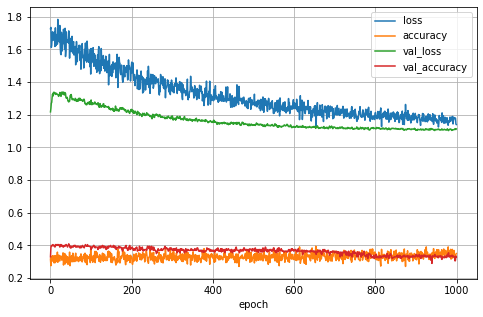

time to execute: 2.35 minutes
Ticker: ['BTC'] returned and average of 0.07 percent over 8.33 days and 44 trades
Started with $5000 and ended with $5129.4

Ticker: ['BTC'] returned and average of 0.41 percent over 8.33 days and 44 trades when setting selling limit
Started with $5000 and ended with $5977.1

percentage correct: 18.18%
Sequence length: 1




1
std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 200
Accuracy with train data: 36.97
Accuracy with validation data: 29.00


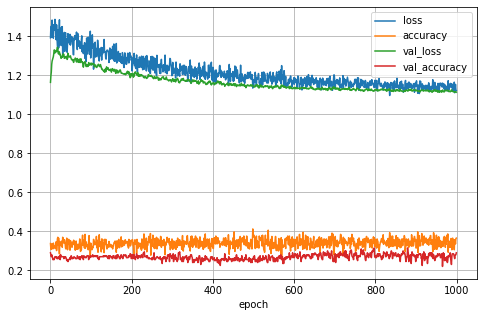

time to execute: 2.44 minutes
Ticker: ['BTC'] returned and average of 0.14 percent over 8.33 days and 70 trades
Started with $5000 and ended with $5513.6

Ticker: ['BTC'] returned and average of 0.35 percent over 8.33 days and 70 trades when setting selling limit
Started with $5000 and ended with $6390.3

percentage correct: 18.57%
Sequence length: 1




1
std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 200
Accuracy with train data: 35.26
Accuracy with validation data: 29.50


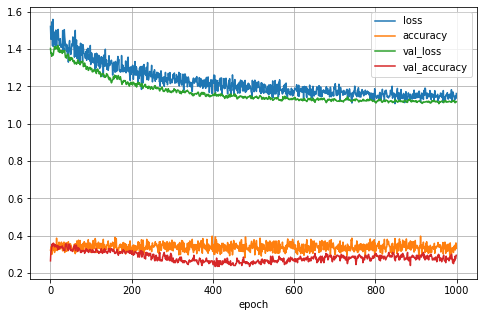

time to execute: 2.51 minutes
Ticker: ['BTC'] returned and average of 0.23 percent over 8.33 days and 81 trades
Started with $5000 and ended with $5987.0

Ticker: ['BTC'] returned and average of 0.48 percent over 8.33 days and 81 trades when setting selling limit
Started with $5000 and ended with $7329.7

percentage correct: 23.46%
Sequence length: 1




2
std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 199
Accuracy with train data: 39.74
Accuracy with validation data: 25.63


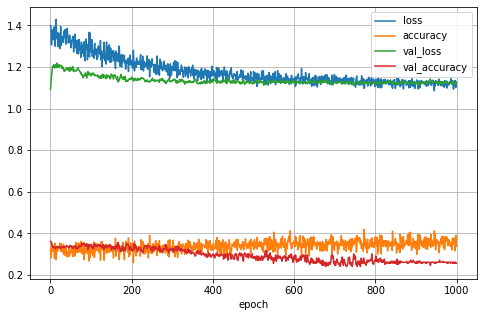

time to execute: 2.18 minutes
Ticker: ['BTC'] returned and average of 0.17 percent over 8.29 days and 91 trades
Started with $5000 and ended with $5793.0

Ticker: ['BTC'] returned and average of 0.42 percent over 8.29 days and 91 trades when setting selling limit
Started with $5000 and ended with $7283.0

percentage correct: 23.08%
Sequence length: 2




2
std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 199
Accuracy with train data: 39.53
Accuracy with validation data: 26.13


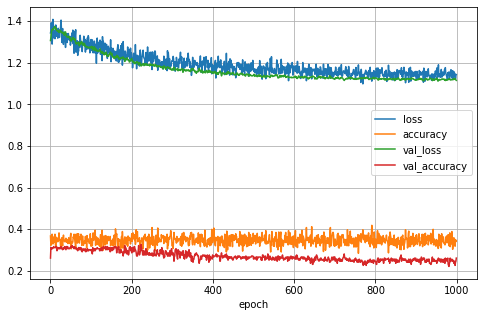

time to execute: 1.7 minutes
Ticker: ['BTC'] returned and average of 0.14 percent over 8.29 days and 86 trades
Started with $5000 and ended with $5626.7

Ticker: ['BTC'] returned and average of 0.39 percent over 8.29 days and 86 trades when setting selling limit
Started with $5000 and ended with $6952.6

percentage correct: 17.44%
Sequence length: 2




2
std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 199
Accuracy with train data: 40.38
Accuracy with validation data: 25.63


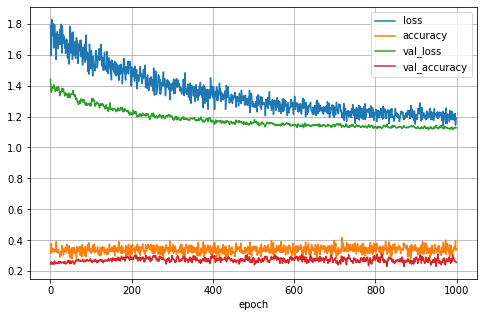

time to execute: 1.62 minutes
Ticker: ['BTC'] returned and average of 0.36 percent over 8.29 days and 76 trades
Started with $5000 and ended with $6507.8

Ticker: ['BTC'] returned and average of 0.61 percent over 8.29 days and 76 trades when setting selling limit
Started with $5000 and ended with $7882.9

percentage correct: 19.74%
Sequence length: 2




3
std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 198
Accuracy with train data: 35.90
Accuracy with validation data: 25.76


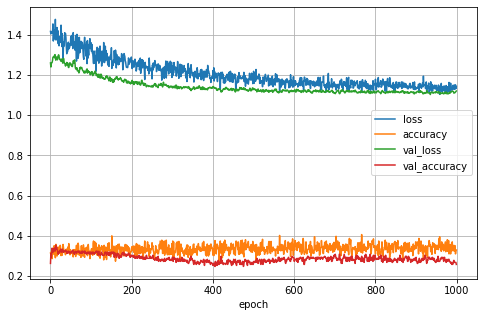

time to execute: 1.66 minutes
Ticker: ['BTC'] returned and average of 0.25 percent over 8.25 days and 85 trades
Started with $5000 and ended with $6150.5

Ticker: ['BTC'] returned and average of 0.47 percent over 8.25 days and 85 trades when setting selling limit
Started with $5000 and ended with $7422.9

percentage correct: 22.35%
Sequence length: 3




3
std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 198
Accuracy with train data: 37.82
Accuracy with validation data: 26.77


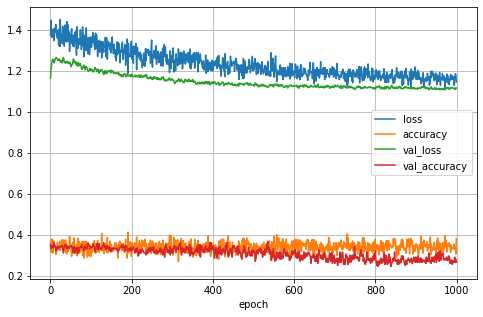

time to execute: 1.78 minutes
Ticker: ['BTC'] returned and average of 0.08 percent over 8.25 days and 70 trades
Started with $5000 and ended with $5276.4

Ticker: ['BTC'] returned and average of 0.42 percent over 8.25 days and 70 trades when setting selling limit
Started with $5000 and ended with $6697.2

percentage correct: 18.57%
Sequence length: 3




3
std: 0.72
std: 0.72
tickers: ['BTC'], train length: 468, validation length: 198
Accuracy with train data: 39.32
Accuracy with validation data: 28.28


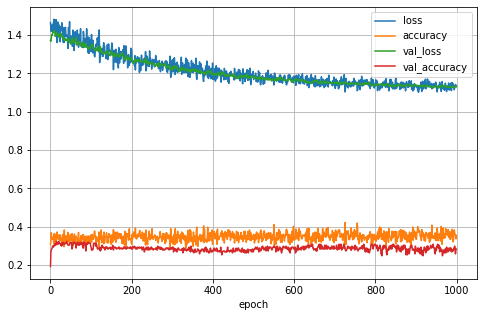

time to execute: 1.88 minutes
Ticker: ['BTC'] returned and average of 0.06 percent over 8.25 days and 82 trades
Started with $5000 and ended with $5223.0

Ticker: ['BTC'] returned and average of 0.4 percent over 8.25 days and 82 trades when setting selling limit
Started with $5000 and ended with $6929.5

percentage correct: 19.51%
Sequence length: 3






In [26]:
# this where I test the models
models = []
ticker = ["BTC"]
i = 1
for SEQ_LEN in range(1,4):
    for iteration in range(3):
        start = time.time()
        print(SEQ_LEN)
#         SEQ_LEN = j + 1
        SHIFT = 200
        score,model,predictions,trainX,trainY,trainPercent,validationX,validationY,validationPercent = main(ticker, SEQ_LEN, SHIFT)
        print("time to execute: {} minutes".format(round((time.time()-start)/60,2)))

        models.append(["model:{}, ticker: {}".format(str(i), ticker[0]), model])

        Return = []; times = 0; timesRight = 0; ReturnS = []
        for i, j, k in zip(predictions, validationY, validationPercent):
            if np.argmax(i, axis=0) == 2:
                Return.append(round(k,2))
                if round(k,2) < -0.2:
                    k = -0.2
                times += 1
                if j == 2:
                    timesRight += 1
                ReturnS.append(k)
        #         print("prediction: {}, actual: {}, and percentage: {}".format(np.argmax(i, axis=0), j, round(k,2)))

        start = 5000; amount = start   
        for i in Return:
            amount = (amount * (i/100)) + amount

        start = 5000; amountS = start   
        for i in ReturnS:
            amountS = (amountS * (i/100)) + amountS

    #     print()
        print("Ticker: {} returned and average of {} percent over {} days and {} trades".format(ticker, round(np.average(Return),2), round(len(predictions)/24,2), len(Return)))
        print("Started with ${} and ended with ${}".format(start, round(amount,1)))
        print()
        print("Ticker: {} returned and average of {} percent over {} days and {} trades when setting selling limit".format(ticker, round(np.average(ReturnS),2), round(len(predictions)/24,2), len(ReturnS)))
        print("Started with ${} and ended with ${}".format(start, round(amountS,1)))
        print()
        print("percentage correct: {}%".format(round(100*(timesRight/times),2)))
        print("Sequence length: {}".format(SEQ_LEN))
        print()
        print()
        print() 
        print()

        i += 1

    

In [52]:
round(len(predictions)/24,2)


8.17

In [54]:
for j in range(1,4):
    print(j)

1
2
3


In [95]:
models

[['model:0, ticker: CLR',
 ['model:1, ticker: CLR',
 ['model:2, ticker: CLR',
 ['model:3, ticker: CLR',
 ['model:4, ticker: CLR',
 ['model:5, ticker: CLR',
 ['model:6, ticker: CLR',
 ['model:7, ticker: CLR',
 ['model:8, ticker: CLR',
 ['model:9, ticker: CLR',
 ['model:10, ticker: CLR',
 ['model:11, ticker: CLR',
 ['model:12, ticker: CLR',
 ['model:13, ticker: CLR',
 ['model:14, ticker: CLR',
 ['model:0, ticker: EQNR',
 ['model:1, ticker: EQNR',
 ['model:2, ticker: EQNR',
 ['model:3, ticker: EQNR',
 ['model:4, ticker: EQNR',
 ['model:5, ticker: EQNR',
 ['model:6, ticker: EQNR',
 ['model:7, ticker: EQNR',
 ['model:8, ticker: EQNR',
 ['model:9, ticker: EQNR',
 ['model:10, ticker: EQNR',
 ['model:11, ticker: EQNR',
 ['model:12, ticker: EQNR',
 ['model:13, ticker: EQNR',
 ['model:14, ticker: EQNR',
 ['model:0, ticker: MPC',
 ['model:1, ticker: MPC',
 ['model:2, ticker: MPC',
 ['model:3, ticker: MPC',
 ['model:4, ticker: MPC',
 ['model:5, ticker: MPC',
 ['model:6, ticker: MPC',
 ['model:7, t

In [77]:
models[0][0] == 'FNGU'

False

In [103]:
ticker = "NTR"
Models = []
for model in models:
    if ticker in model[0]:
        Models.append(model[1])

In [100]:
Models

In [42]:
Models = []
for row in models:
    Models.append(row[1])

In [43]:
Models

In [93]:
ticker = Tickers[0][0]
print(ticker)
os.listdir(ticker)

CLR


['CLR_model4.h5',
 'CLR_model1.h5',
 'CLR_model5.h5',
 'CLR_model2.h5',
 'CLR_model3.h5']

In [104]:
ticker = Tickers[0][0]
ticker = "NTR"
List = os.listdir(ticker) # dir is your directory path
num = len(List) - 1
num = 1
for model in Models:
    if os.path.isfile(ticker+'/'+ticker+'_model'+str(num)+'.h5') is False:
        model.save(ticker+'/'+ticker+'_model'+str(num)+'.h5')
        num += 1


In [46]:
Return = []; times = 0; timesRight = 0; ReturnS = []
for i, j, k in zip(predictions, validationY, validationPercent):
    if np.argmax(i, axis=0) == 2:
        Return.append(round(k,2))
        if round(k,2) < -2:
            k = -2
        times += 1
        if j == 2:
            timesRight += 1
        ReturnS.append(k)
        print("prediction: {}, actual: {}, and percentage: {}".format(np.argmax(i, axis=0), j, round(k,2)))

start = 5000; amount = start   
for i in Return:
    amount = (amount * (i/100)) + amount

start = 5000; amountS = start   
for i in ReturnS:
    amountS = (amountS * (i/100)) + amountS

print()
print("Ticker: {} returned and average of {} percent over {} days and {} trades".format(tickers, round(np.average(Return),2), len(predictions), len(Return)))
print("Started with ${} and ended with ${}".format(start, round(amount,1)))
print()
print("Ticker: {} returned and average of {} percent over {} days and {} trades when setting selling limit".format(tickers, round(np.average(ReturnS),2), len(predictions), len(ReturnS)))
print("Started with ${} and ended with ${}".format(start, round(amountS,1)))
print()
print("percentage correct: {}%".format(round(100*(timesRight/times),2)))
# print("Sequence length: {}".format(SEQ_LEN))
print()
print()
print() 
print()
        

prediction: 2, actual: 1, and percentage: -2
prediction: 2, actual: 1, and percentage: -2
prediction: 2, actual: 2, and percentage: 2.95
prediction: 2, actual: 2, and percentage: 3.03
prediction: 2, actual: 2, and percentage: 3.82
prediction: 2, actual: 1, and percentage: -2
prediction: 2, actual: 0, and percentage: -0.43
prediction: 2, actual: 0, and percentage: 1.89
prediction: 2, actual: 0, and percentage: -0.92
prediction: 2, actual: 0, and percentage: -0.73
prediction: 2, actual: 2, and percentage: 4.3
prediction: 2, actual: 0, and percentage: -1.69
prediction: 2, actual: 0, and percentage: 0.17
prediction: 2, actual: 0, and percentage: -1.2
prediction: 2, actual: 0, and percentage: -0.81
prediction: 2, actual: 0, and percentage: -0.37
prediction: 2, actual: 0, and percentage: -1.64
prediction: 2, actual: 2, and percentage: 2.97
prediction: 2, actual: 2, and percentage: 2.97
prediction: 2, actual: 0, and percentage: -1.6
prediction: 2, actual: 1, and percentage: -2
prediction: 2, 

In [31]:

ticker = "HIBL"
List = os.listdir(ticker)
List

['HIBL_model9.h5',
 'HIBL_model13.h5',
 'HIBL_model8.h5',
 'HIBL_model12.h5',
 'HIBL_model7.h5',
 'HIBL_model3.h5',
 'HIBL_model2.h5',
 'HIBL_model6.h5',
 'HIBL_model1.h5',
 'HIBL_model5.h5',
 'HIBL_model4.h5',
 'HIBL_model11.h5',
 'HIBL_model15.h5',
 'HIBL_model14.h5',
 'HIBL_model10.h5']

In [116]:

# ticker = tickers[0]
ticker = "NTR"
List = os.listdir(ticker)
for m in List:
    if 'model' in ticker+'/'+m:
        model = load_model(ticker+'/'+m)
    
        predictions = (model.predict(validationX))
        
        
        Return = []; times = 0; timesRight = 0; ReturnS = []
        for i, j, k in zip(predictions, validationY, validationPercent):
            if np.argmax(i, axis=0) == 2:
                Return.append(round(k,2))
                if round(k,2) < -2:
                    k = -2
                times += 1
                if j == 2:
                    timesRight += 1
                ReturnS.append(k)
        #         print("prediction: {}, actual: {}, and percentage: {}".format(np.argmax(i, axis=0), j, round(k,2)))

        start = 5000; amount = start   
        for i in Return:
            amount = (amount * (i/100)) + amount

        start = 5000; amountS = start   
        for i in ReturnS:
            amountS = (amountS * (i/100)) + amountS

        print()
        print("results for model: {}".format(m))
        print("Ticker: {} returned and average of {} percent over {} days and {} trades".format(ticker, round(np.average(Return),2), len(predictions), len(Return)))
        print("Started with ${} and ended with ${}".format(start, round(amount,1)))
        print()
        print("Ticker: {} returned and average of {} percent over {} days and {} trades when setting selling limit".format(ticker, round(np.average(ReturnS),2), len(predictions), len(ReturnS)))
        print("Started with ${} and ended with ${}".format(start, round(amountS,1)))
        print()
        print("percentage correct: {}%".format(round(100*(timesRight/times),2)))
        # print("Sequence length: {}".format(SEQ_LEN))
        print()
        print()
        print() 
        print()
        
        



results for model: NTR_model4.h5
Ticker: NTR returned and average of 0.48 percent over 73 days and 19 trades
Started with $5000 and ended with $5463.0

Ticker: NTR returned and average of 0.5 percent over 73 days and 19 trades when setting selling limit
Started with $5000 and ended with $5480.2

percentage correct: 42.11%





results for model: NTR_model12.h5
Ticker: NTR returned and average of 0.56 percent over 73 days and 16 trades
Started with $5000 and ended with $5441.2

Ticker: NTR returned and average of 0.83 percent over 73 days and 16 trades when setting selling limit
Started with $5000 and ended with $5701.0

percentage correct: 43.75%





results for model: NTR_model8.h5
Ticker: NTR returned and average of 0.16 percent over 73 days and 16 trades
Started with $5000 and ended with $5115.6

Ticker: NTR returned and average of 0.25 percent over 73 days and 16 trades when setting selling limit
Started with $5000 and ended with $5193.0

percentage correct: 37.5%





results fo

In [26]:
trainX.shape

(363, 3, 6)

In [15]:
Tickers = [
    ["UPRO"],["SPXL"],["UPRO"],["UDOW"],["GUSH"],["TMF"],
    ["URTY"],["DFEN"],["NAIL"],["CURE"],["EDC"],["WEBL"],
    ["DRN"],["RETL"],["INDL"],["HIBL"],["MIDU"],["TPOR"],
    ["DUSL"],["UMDD"],["WANT"],["EURL"],["KORU"],["UBOT"],
    ["UTSL"],["PILL"],["TYD"],["MEXX"],["BNKU"],["BULZ"],
    ["FNGU"],["NRGU"],["OILU"]
]

In [18]:
Tickers = [
    ["UPRO"],["SPXL"],["UPRO"],["UDOW"],["GUSH"],["TMF"],
    ["URTY"],["DFEN"],["NAIL"],["CURE"],["EDC"],["WEBL"],
    ["DRN"],["RETL"],["INDL"],["HIBL"],["MIDU"],["TPOR"],
    ["DUSL"],["UMDD"],["WANT"],["EURL"],["KORU"],["UBOT"],
    ["UTSL"],["PILL"],["MEXX"],["BNKU"],
    ["FNGU"],["GDXU"],["NRGU"]
]

In [19]:

for tickers in Tickers:
    SHIFT = 75
    SEQ_LEN = 2
    trainX, trainY, trainPercent = trainData(SEQ_LEN, SHIFT, tickers)
    validationX, validationY, validationPercent = testData(SEQ_LEN, SHIFT, tickers)
    print("tickers: {}, train length: {}, validation length: {}".format(tickers, len(trainX), len(validationX)))
    print()

std: 1.32
std: 1.32
tickers: ['UPRO'], train length: 435, validation length: 74

std: 1.3
std: 1.3
tickers: ['SPXL'], train length: 432, validation length: 74

std: 1.32
std: 1.32
tickers: ['UPRO'], train length: 435, validation length: 74

std: 1.33
std: 1.33
tickers: ['UDOW'], train length: 423, validation length: 74

std: 2.94
std: 2.94
tickers: ['GUSH'], train length: 525, validation length: 74

std: 1.09
std: 1.09
tickers: ['TMF'], train length: 414, validation length: 74

std: 1.92
std: 1.92
tickers: ['URTY'], train length: 522, validation length: 74

std: 2.01
std: 2.01
tickers: ['DFEN'], train length: 474, validation length: 74

std: 2.68
std: 2.68
tickers: ['NAIL'], train length: 492, validation length: 74

std: 1.4
std: 1.4
tickers: ['CURE'], train length: 456, validation length: 74

std: 1.05
std: 1.05
tickers: ['EDC'], train length: 537, validation length: 74

std: 2.19
std: 2.19
tickers: ['WEBL'], train length: 318, validation length: 74

std: 1.8
std: 1.8
tickers: ['DRN']